In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
# Load the Data

data_dir = pathlib.Path('./data/tiny-imagenet-200')
image_count = len(list(data_dir.glob('**/*.JPEG')))
CLASS_NAMES = np.array([item.name for item in (data_dir / 'train').glob('*')])
num_classes = len(CLASS_NAMES)
print('Discovered {} images in {} classes'.format(image_count, num_classes))

# Create the training data generator
batch_size = 32
im_height = 64
im_width = 64
num_epochs = 1

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), tuple(np.sqrt((255, 255, 255)))),
])

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=data_dir / 'train', transform=data_transforms),
    'valid': datasets.ImageFolder(root=data_dir / 'val', transform=data_transforms),
    'test': datasets.ImageFolder(root=data_dir / 'test', transform=data_transforms)
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batch_size, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

Discovered 129998 images in 200 classes
{0: 'n01443537', 1: 'n01629819', 2: 'n01641577', 3: 'n01644900', 4: 'n01698640', 5: 'n01742172', 6: 'n01768244', 7: 'n01770393', 8: 'n01774384', 9: 'n01774750', 10: 'n01784675', 11: 'n01855672', 12: 'n01882714', 13: 'n01910747', 14: 'n01917289', 15: 'n01944390', 16: 'n01945685', 17: 'n01950731', 18: 'n01983481', 19: 'n01984695', 20: 'n02002724', 21: 'n02056570', 22: 'n02058221', 23: 'n02074367', 24: 'n02085620', 25: 'n02094433', 26: 'n02099601', 27: 'n02099712', 28: 'n02106662', 29: 'n02113799', 30: 'n02123045', 31: 'n02123394', 32: 'n02124075', 33: 'n02125311', 34: 'n02129165', 35: 'n02132136', 36: 'n02165456', 37: 'n02190166', 38: 'n02206856', 39: 'n02226429', 40: 'n02231487', 41: 'n02233338', 42: 'n02236044', 43: 'n02268443', 44: 'n02279972', 45: 'n02281406', 46: 'n02321529', 47: 'n02364673', 48: 'n02395406', 49: 'n02403003', 50: 'n02410509', 51: 'n02415577', 52: 'n02423022', 53: 'n02437312', 54: 'n02480495', 55: 'n02481823', 56: 'n02486410', 

In [5]:
# Load pretrained ResNet50 Model
model = models.resnet50(pretrained=False)

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
model = model.to('cuda:0')

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

best_model_path = "./model_best_resnet50.pth"
# model = torch.load(best_model_path)
state_dict = torch.load(best_model_path)['state_dict']
model.load_state_dict({k[7:]: v for k, v in state_dict.items()})
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# FGSM attack code, from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

top1 = AverageMeter('Acc@1', ':6.2f')

In [8]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [9]:
def test(model, device, loss_func, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []
    
    progress = ProgressMeter(
        len(test_loader),
        [top1])
    print_freq = 500

    # Loop over all examples in test set
    for i, (data, target) in enumerate(test_loader):
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
#         if init_pred.item() != target.item():
#             continue

        # Calculate the loss
        loss = loss_func(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        acc1 = accuracy(output, target, topk=(1,))
        top1.update(acc1[0].item(), data.size(0))
        
        if len(adv_examples) < 3:
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.detach().cpu().numpy(), final_pred.detach().cpu().numpy(), adv_ex) )
        
#         if i % print_freq == 0:
#             print(i, top1.avg)
#         final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#         if final_pred.item() == target.item():
#             correct += 1
#             # Special case for saving 0 epsilon examples
#             if (epsilon == 0) and (len(adv_examples) < 5):
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
#         else:
#             # Save some adv examples for visualization later
#             if len(adv_examples) < 5:
#                 adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
#                 adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
#     final_acc = correct/float(len(test_loader))
    final_acc = top1.avg
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, top1.sum, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [36]:
accuracies = []
examples = []
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

loss_func = nn.CrossEntropyLoss().cuda(device)
optimizer = optim.Adam(model.parameters())

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, loss_func, valid_data_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = tensor([33600.], device='cuda:0') / 313 = tensor([0.7153], device='cuda:0')
Epsilon: 0.05	Test Accuracy = tensor([37700.], device='cuda:0') / 313 = tensor([0.6617], device='cuda:0')
Epsilon: 0.1	Test Accuracy = tensor([43200.], device='cuda:0') / 313 = tensor([0.6451], device='cuda:0')
Epsilon: 0.15	Test Accuracy = tensor([48800.], device='cuda:0') / 313 = tensor([0.6340], device='cuda:0')
Epsilon: 0.2	Test Accuracy = tensor([54000.], device='cuda:0') / 313 = tensor([0.6209], device='cuda:0')
Epsilon: 0.25	Test Accuracy = tensor([59100.], device='cuda:0') / 313 = tensor([0.6095], device='cuda:0')
Epsilon: 0.3	Test Accuracy = tensor([64600.], device='cuda:0') / 313 = tensor([0.6039], device='cuda:0')


In [10]:
accuracies = []
examples = []
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

loss_func = nn.CrossEntropyLoss().cuda(device)
optimizer = optim.Adam(model.parameters())

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, loss_func, valid_data_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 6500.0 / 313 = 0.65006500650065
Epsilon: 0.05	Test Accuracy = 11300.0 / 313 = 0.5650565056505651
Epsilon: 0.1	Test Accuracy = 16100.0 / 313 = 0.5367203387005367
Epsilon: 0.15	Test Accuracy = 21300.0 / 313 = 0.5325532553255325
Epsilon: 0.2	Test Accuracy = 26400.0 / 313 = 0.528052805280528
Epsilon: 0.25	Test Accuracy = 31300.0 / 313 = 0.5217188385505217
Epsilon: 0.3	Test Accuracy = 36300.0 / 313 = 0.5186232909005186


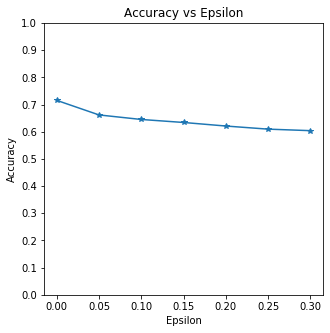

In [37]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [55]:
np.array(examples[0][0][2][0,:,:,:]).shape

(3, 64, 64)

In [61]:
examples[0][0][2][0,:,:,:]

array([[[0.01645374, 0.01547142, 0.0213653 , ..., 0.01669932,
         0.01940067, 0.01178775],
        [0.01743605, 0.0135068 , 0.0213653 , ..., 0.00736734,
         0.01719047, 0.01989183],
        [0.01596258, 0.01620816, 0.015717  , ..., 0.01252449,
         0.01964625, 0.01227891],
        ...,
        [0.05230815, 0.05476393, 0.04665985, ..., 0.02431224,
         0.03806461, 0.02332992],
        [0.04739659, 0.04985237, 0.05206257, ..., 0.02554013,
         0.02652244, 0.02578571],
        [0.05893876, 0.04297618, 0.04911563, ..., 0.02062857,
         0.03388979, 0.02775033]],

       [[0.01620816, 0.01522585, 0.02111972, ..., 0.01277006,
         0.01547142, 0.00761292],
        [0.01645374, 0.01326122, 0.02111972, ..., 0.00343809,
         0.01326122, 0.01645374],
        [0.01498027, 0.01522585, 0.01547142, ..., 0.00859524,
         0.01620816, 0.00884081],
        ...,
        [0.04739659, 0.04936121, 0.04101155, ..., 0.02332992,
         0.03609999, 0.0213653 ],
        [0.0

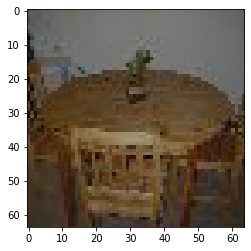

In [15]:
plt.imshow(np.transpose(examples[0][0][2][2,:,:,:] * 10, (1, 2, 0)))

In [103]:
import time

def validate(val_loader, model, criterion, gpu):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if gpu is not None:
                images = images.cuda(gpu, non_blocking=True)
            target = target.cuda(gpu, non_blocking=True)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 500 == 0:
                progress.display(i)


        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg

validate(train_data_loader, model, loss_func, "cuda")

Test: [   0/3125]	Time  0.793 ( 0.793)	Loss 8.2536e+00 (8.2536e+00)	Acc@1   6.25 (  6.25)	Acc@5   9.38 (  9.38)
Test: [ 500/3125]	Time  0.863 ( 0.719)	Loss 8.7623e+00 (9.3959e+00)	Acc@1   3.12 (  0.63)	Acc@5   6.25 (  3.18)
Test: [1000/3125]	Time  0.643 ( 0.719)	Loss 9.3307e+00 (9.4031e+00)	Acc@1   0.00 (  0.72)	Acc@5   9.38 (  3.15)


KeyboardInterrupt: 

In [87]:
def testv2(model, device, loss_func, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []
    
    progress = ProgressMeter(
        len(test_loader),
        [top1])
    print_freq = 500

    # Loop over all examples in test set
    for i, (data, target) in enumerate(test_loader):
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = loss_func(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        acc1 = accuracy(output, target, topk=(1,))
        top1.update(acc1[0].item(), data.size(0))
        
        if len(adv_examples) < 3:
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            orig = data.squeeze().detach().cpu().numpy()
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.detach().cpu().numpy(), final_pred.detach().cpu().numpy(), orig, adv_ex) )
        else:
            return top1.avg, adv_examples

    # Calculate final accuracy for this epsilon
#     final_acc = correct/float(len(test_loader))
    final_acc = top1.avg
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, top1.sum, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [91]:
accuracies = []
examples = []
epsilons = [0, 0.05]

loss_func = nn.CrossEntropyLoss().cuda(device)
optimizer = optim.Adam(model.parameters())

# Run test for each epsilon
for eps in epsilons:
    acc, ex = testv2(model, device, loss_func, valid_data_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: tuple index out of range

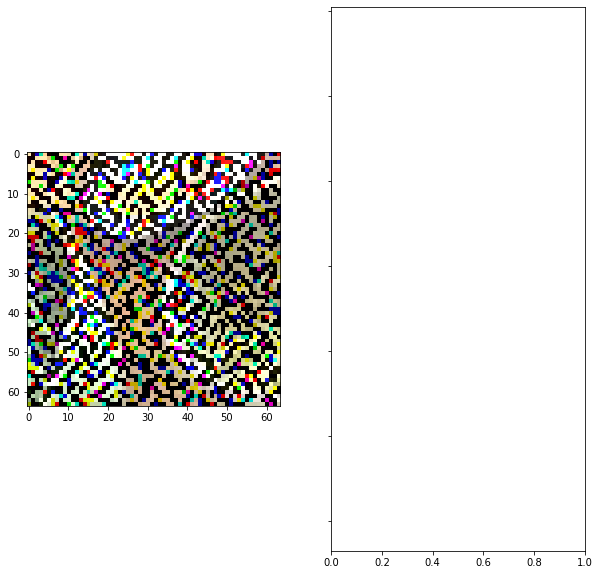

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,10))
ax1.imshow(np.transpose(examples[1][0][2][2,:,:,:] * 10, (1, 2, 0)))
ax2.imshow(np.transpose(examples[1][0][3][2,:,:,:] * 10, (1, 2, 0)))

In [7]:
def plot_result(x_scale, tr, val, title, y_label, ax=plt):
    ax.set_title(title)
    if title == 'loss':
        ax.plot(x_scale, tr, label='training loss')
        ax.plot(x_scale, val, label='validation loss')
    else:
        ax.plot(x_scale, tr, label='training accuracy')
        ax.plot(x_scale, val, label='validation accuracy')
    ax.set_xlabel("Epochs")
    ax.set_ylabel(y_label)
    ax.legend()

def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=10, verbose=True, save=True):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    tr_acc, val_acc = [], []
    tr_loss, val_loss  = [], []
    
    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1), end=": ")
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                tr_acc.append(epoch_acc)
                tr_loss.append(epoch_loss)
            elif phase == 'val':
                val_acc.append(epoch_acc)
                val_loss.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        if verbose:        
            print('Training Loss: {:.4f}, Acc: {:.4f}; Validation Loss: {:.4f}, Acc: {:.4f}'.format(
                tr_loss[-1], tr_acc[-1], val_loss[-1], val_acc[-1]))
        if save:
            torch.save(model.state_dict(), './models/resnet152_best_model_epoch_' + str(epoch) + '.pth')
            np.save('full_training.npy', np.array([tr_acc, val_acc, tr_loss, val_loss]))

    time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, tr_acc, val_acc, tr_loss, val_loss

In [19]:
import resnet_modified
model = resnet_modified.resnet152(pretrained=False, decay_factor=0.04278)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Freeze model parameters
# for param in model.parameters():
#     param.requires_grad = False

In [20]:
best_model_path = "./models/resnet152_best_model_state_dict.pth"
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [32]:
def validate_fgsm(model, criterion, optimizer, scheduler, dataloaders, epsilon, num_epochs=1, verbose=True, save=True):
    since = time.time()

    tr_acc, val_acc = [], []
    tr_loss, val_loss  = [], []
    
    adv_examples = []
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    
    for epoch in range(num_epochs):
        if verbose:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1), end=": ")
        
        # Each epoch has a training and validation phase
        phase = 'val'
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
            if phase == 'train':
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()
            else:
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                init_pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability

                # Zero all existing gradients
                model.zero_grad()

                # Calculate gradients of model in backward pass
                loss.backward()

                # Collect datagrad
                data_grad = inputs.grad.data

                # Call FGSM Attack
                perturbed_data = fgsm_attack(inputs, epsilon, data_grad)

                # Re-classify the perturbed image
                outputs = model(perturbed_data)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if len(adv_examples) < 3:
                    final_pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.detach().cpu().numpy(), final_pred.detach().cpu().numpy(), adv_ex) )
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        if phase == 'train':
            tr_acc.append(epoch_acc)
            tr_loss.append(epoch_loss)
        elif phase == 'val':
            val_acc.append(epoch_acc)
            val_loss.append(epoch_loss)
        
        if verbose:        
            print('Validation Loss: {:.4f}, Acc: {:.4f}'.format(
                val_loss[-1], val_acc[-1]))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return val_acc[0], val_loss[0], adv_examples

In [10]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), tuple(np.sqrt((255, 255, 255)))),
])

# Load Data from folders
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=data_transforms),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms)
}

phases = ['train', 'val', 'test']

dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
              'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True),
              'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)}

In [33]:
accuracies = []
losses = []
examples = []
epsilons = [0, 5e-3, 1e-2, 1.5e-2, 2e-2, 2.5e-2]

lr = 2.61e-5
loss_func = nn.CrossEntropyLoss().cuda(device)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
# optimizer_ft = optim.Adam(model.parameters(), lr=lr)

# Run test for each epsilon
for eps in epsilons:
    acc, loss, ex = validate_fgsm(model, loss_func, optimizer_ft, None, dataloaders, eps, verbose=False)
    accuracies.append(acc)
    losses.append(loss)
    examples.append(ex)
    print('Epsilon: {}, Accuracy: {}, Loss: {}'.format(eps, acc, loss))
    np.save('fgsm_data.npy', np.array([eps, accuracies, losses, examples]))

Training complete in 3m 2s
Epsilon: 0, Accuracy: 0.6374637463746374, Loss: 1.510921383490621
Training complete in 3m 1s
Epsilon: 0.005, Accuracy: 0.05310531053105311, Loss: 6.958281991815362
Training complete in 3m 1s
Epsilon: 0.01, Accuracy: 0.024102410241024105, Loss: 7.787095042273621
Training complete in 3m 1s
Epsilon: 0.015, Accuracy: 0.0098009800980098, Loss: 8.507041253594354
Training complete in 3m 2s
Epsilon: 0.02, Accuracy: 0.0079007900790079, Loss: 8.48033754123856
Training complete in 3m 1s
Epsilon: 0.025, Accuracy: 0.007600760076007601, Loss: 7.9797646121175685


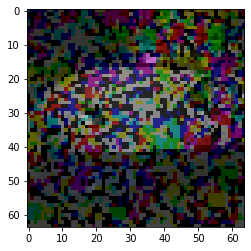

In [40]:
plt.imshow(np.transpose(examples[4][0][2][2,:,:,:] * 10, (1, 2, 0)))